In [1]:
import pandas as pd
from SpaMCA.preprocess import pca, fix_seed, lsi, clr_normalize_each_cell
import warnings

warnings.filterwarnings('ignore')

# Import necessary Python libraries
import os  # Operating system functionality
import torch  # PyTorch deep learning framework
import scanpy as sc  # Single-cell data analysis toolkit
from SpaMCA.utils import clustering
from SpaMCA.SpaMCA_Py import Train_SpaMCA
from SpaMCA.preprocess import construct_neighbor_graph

# Set R environment path (required for R-based functions)
R_HOME = r"D:\Environment\R-4.5.0"  # Path to R installation
os.environ["R_HOME"] = R_HOME  # Add R path to system environment variables
# Define data folder path
DATA_FOLDER = 'D:/Work2/多组学数据/Dataset11_Human_Lymph_Node_A1/'
TRUTH_FILE = 'D:/Work2/多组学数据/Dataset11_Human_Lymph_Node_A1/annotation.csv'

fix_seed(2022)
# 
Truth = pd.read_csv(TRUTH_FILE, sep=',', header=None, index_col=0)
Truth.columns = ['Ground Truth']

# 
adata_omics1 = sc.read_h5ad(DATA_FOLDER + 'adata_RNA.h5ad')  # 
adata_omics2 = sc.read_h5ad(DATA_FOLDER + 'adata_ADT.h5ad')  # 

#  
adata_omics1.obs['layer_guess'] = Truth.loc[adata_omics1.obs_names, 'Ground Truth']
adata_omics1 = adata_omics1[~pd.isnull(adata_omics1.obs['layer_guess'])]
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

# 
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars - 1)

# 
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars - 1)

# Data type setting
DATA_TYPE = 'A1'  # Set to 'SL' (specific dataset type)

CLUSTERING_TOOL = 'mclust'  # Using mclust for clustering
N_CLUSTERS = 10  # Set to identify 5 clusters
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=DATA_TYPE)

#  Initialize the SpaMCA model with the constructed neighbor graph and specified parameters
model = Train_SpaMCA(
    data,
    datatype=DATA_TYPE,
    device=DEVICE,
)
output = model.train()

# Train the SpaMCA model and obtain the output
adata = adata_omics1.copy()
adata.obsm['SpaMCA'] = output['SpaMCA'].copy()

# Perform clustering on the SpaMCA embeddings to identify cell types
clustering(
    adata,
    key='SpaMCA',
    add_key=CLUSTERING_TOOL,
    n_clusters=N_CLUSTERS,
    method=CLUSTERING_TOOL,
    use_pca=True
)

100%|██████████| 600/600 [00:11<00:00, 52.27it/s, Loss=0.6492, clust=1.8162, hc=0.0165, inst=0.0863, recon1=3.4611, recon2=0.7705]


Model training finished!



R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [3]:
from sklearn import preprocessing, metrics

labels_true = adata.obs['layer_guess'].astype(str).to_numpy()
labels_pred = adata.obs['mclust'].astype(str).to_numpy()

# 
le_true = preprocessing.LabelEncoder()
labels_true_int = le_true.fit_transform(labels_true)
le_pred = preprocessing.LabelEncoder()
labels_pred_int = le_pred.fit_transform(labels_pred)

#  ARI
current_ari = metrics.adjusted_rand_score(labels_true_int, labels_pred_int)  # 

print(current_ari)

0.3063860613456277


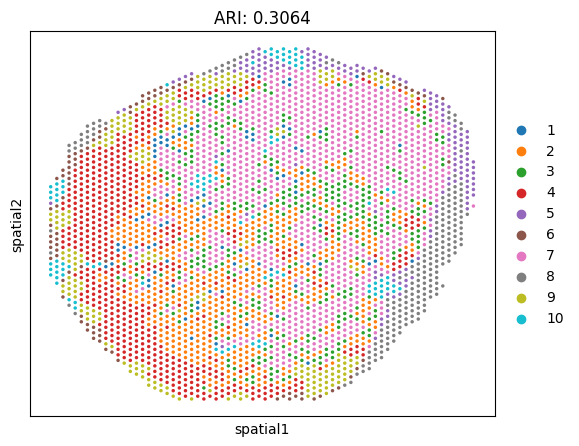

In [4]:
from matplotlib import pyplot as plt

fig, ax_list = plt.subplots(1, 1, figsize=(6, 5))

sc.pl.embedding(
    adata,  # AnnData object containing the spatial coordinates and clustering results
    basis='spatial',  # Use the spatial coordinates stored in adata.obsm['spatial']
    color='mclust',  # Color cells according to their cluster assignments in 'mclust' column
    title=f"ARI: {current_ari:.4f}",  # Set plot title showing ARI score with 4 decimal precision
    s=25,  # Set point size to 25 for better visibility
    show=False,  # Prevent automatic display of the plot (we'll use plt.show() later)
    ax=ax_list  # Pass the single Axes object here
)

plt.show()